In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, gamma

In [2]:
ALPHA = 0.11

Read the data

In [3]:
Dat = pd.read_csv('Data/Howell1.csv', sep=';')
DatAdults = Dat[Dat['age'] >= 18].reset_index(drop=True)

In [4]:
WeightMin, WeightMax, WeightMean = DatAdults['weight'].min(), DatAdults['weight'].max(), DatAdults['weight'].mean()

How to determine a good prior for $\beta$?

In [5]:
MuAlpha = 167
SAlpha  = 3

SSigma  = 10

In [6]:
NPrior = 100

SampleAlpha = norm.rvs(size=NPrior, loc=MuAlpha, scale=SAlpha)
SampleBeta  = norm.rvs(size=NPrior, loc=0, scale=3)

Text(0, 0.5, 'Average Height')

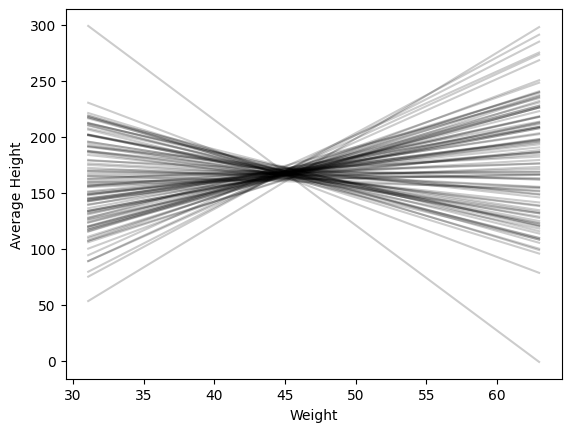

In [7]:
_ = plt.plot(
    [WeightMin, WeightMax]
    , [SampleAlpha + SampleBeta * (WeightMin-WeightMean), SampleAlpha + SampleBeta * (WeightMax-WeightMean)]
    , color='k'
    , alpha=0.2
)

plt.xlabel('Weight')
plt.ylabel('Average Height')

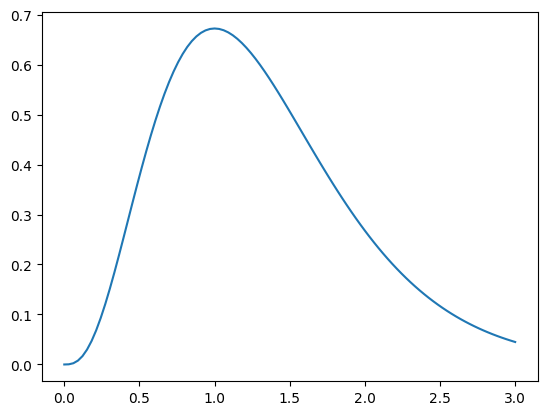

In [8]:
Bb = 3
rv = gamma(a=Bb+1, scale=1/Bb)

BetaVect = np.linspace(0, 3, 100)
plt.plot(BetaVect, rv.pdf(BetaVect))

In [9]:
SampleBeta = gamma.rvs(size=NPrior, a=Bb+1, scale=1/Bb)

Text(0, 0.5, 'Average Height')

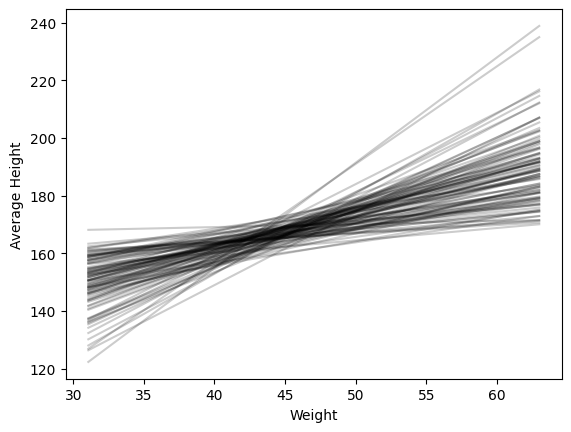

In [10]:
_ = plt.plot(
    [WeightMin, WeightMax]
    , [SampleAlpha + SampleBeta * (WeightMin-WeightMean), SampleAlpha + SampleBeta * (WeightMax-WeightMean)]
    , color='k'
    , alpha=0.2
)

plt.xlabel('Weight')
plt.ylabel('Average Height')

Create the grid for the parameters

In [11]:
AlphaGrid = np.linspace(153.5, 155.5, 50)
BetaGrid  = np.linspace(0.5, 1.5, 50)
SigmaGrid = np.linspace(4, 6, 50)

AlphaGrid, BetaGrid, SigmaGrid = np.meshgrid(AlphaGrid, BetaGrid, SigmaGrid)

Calculate the log-likelihood for the grid

In [12]:
Loglike = []

for i in range(len(AlphaGrid.ravel())):
    mu = AlphaGrid.ravel()[i] + BetaGrid.ravel()[i] * (DatAdults['weight'] - WeightMean)
    Loglike.append(norm.logpdf(DatAdults['height']-mu, 0, SigmaGrid.ravel()[i]).sum())
    
Loglike = np.array(Loglike).reshape(AlphaGrid.shape)

Calculate the log-posterior for the grid

In [13]:
LogPosterior = Loglike \
    + norm.logpdf(AlphaGrid, MuAlpha, SAlpha) \
        + gamma.logpdf(BetaGrid, a=Bb+1, scale=1/Bb) \
            + uniform.logpdf(SigmaGrid, loc=0, scale=SSigma)

Sample from the posterior

In [14]:
NSample = 10**4

Candidates = pd.DataFrame(np.c_[AlphaGrid.ravel(), BetaGrid.ravel(), SigmaGrid.ravel()], columns=['alpha', 'beta', 'sigma'])
SampleId = random.choices(range(Candidates.shape[0]), weights=np.exp(LogPosterior - LogPosterior.max()).ravel(), k=NSample)

SamplePosterior = Candidates.iloc[SampleId]

<Axes: xlabel='alpha', ylabel='beta'>

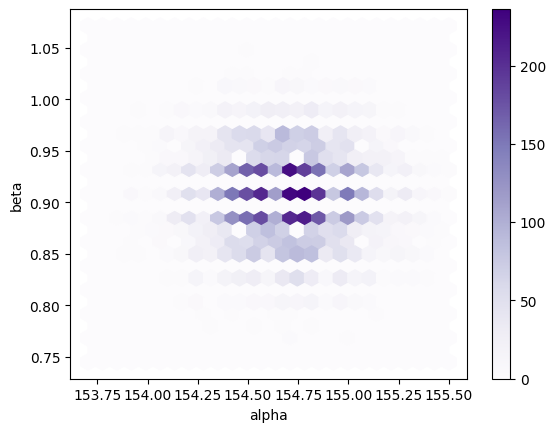

In [15]:
SamplePosterior.plot.hexbin(x='alpha', y='beta', cmap='Purples', gridsize=25)

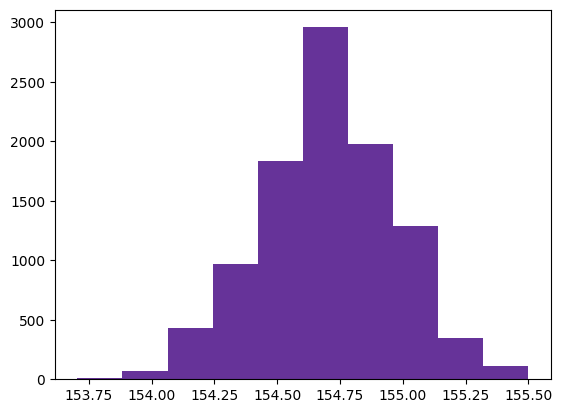

In [16]:
_ = plt.hist(SamplePosterior['alpha'], color='rebeccapurple')

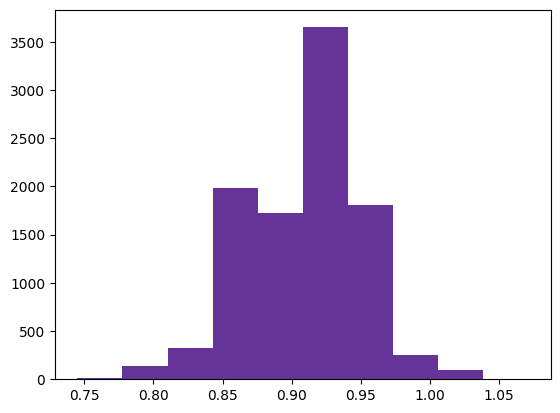

In [17]:
_ = plt.hist(SamplePosterior['beta'], color='rebeccapurple')

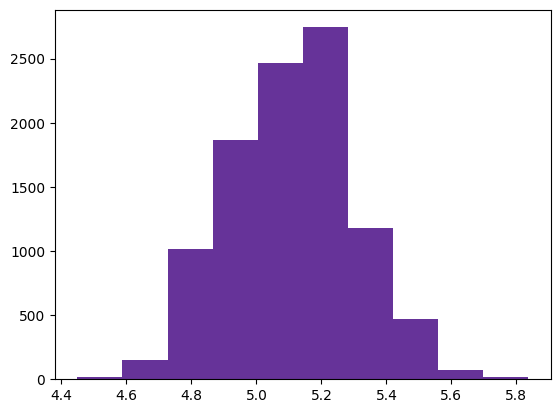

In [18]:
_ = plt.hist(SamplePosterior['sigma'], color='rebeccapurple')

In [19]:
SamplePosterior.describe()

,alpha,beta,sigma
count,10000.000000,10000.000000,10000.000000
mean,154.697600,0.906053,5.102755
std,0.267487,0.041832,0.192703
min,153.704082,0.744898,4.448980
25%,154.520408,0.887755,4.979592
50%,154.683673,0.908163,5.102041
75%,154.887755,0.928571,5.224490
max,155.500000,1.071429,5.836735


Model considering the MAPs for $\alpha$ and $\beta$

In [20]:
AlphaMap = SamplePosterior['alpha'].mode()
BetaMap  = SamplePosterior['beta'].mode()

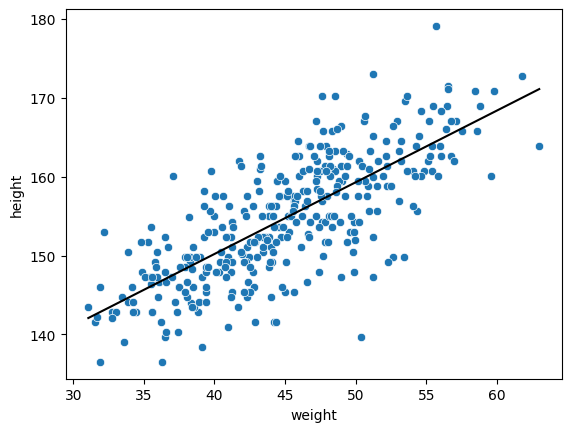

In [21]:
sns.scatterplot(data=DatAdults, x='weight', y='height')

plt.plot(
    [WeightMin, WeightMax],
    [AlphaMap + BetaMap * (WeightMin-WeightMean), AlphaMap + BetaMap * (WeightMax - WeightMean)],
    color='k'
)

Plotting all the samples of a posteriori models

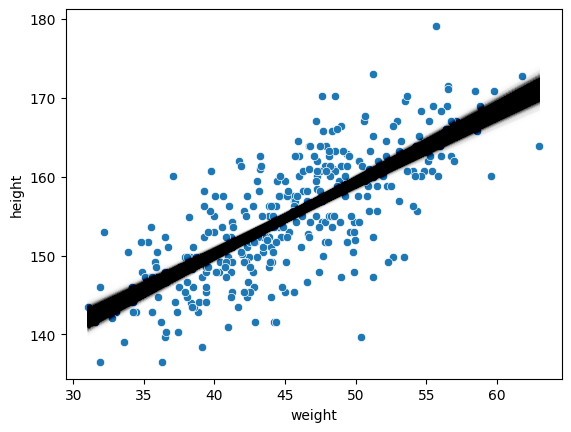

In [22]:
sns.scatterplot(data=DatAdults, x='weight', y='height')

_ = plt.plot(
    [WeightMin, WeightMax],
    [
        SamplePosterior['alpha'] + SamplePosterior['beta'] * (WeightMin - WeightMean)
        , SamplePosterior['alpha'] + SamplePosterior['beta'] * (WeightMax - WeightMean)
    ],
    color='k',
    alpha=0.005
)

How much is $\mu$ for a given weight?

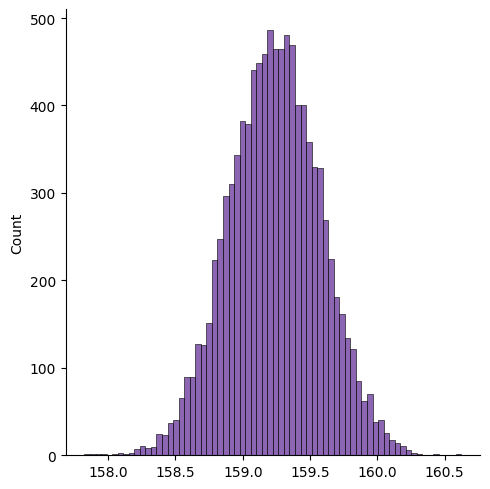

In [23]:
Weight = 50
sns.displot(SamplePosterior['alpha'] + SamplePosterior['beta'] * (Weight-WeightMean), color='rebeccapurple')

Obtaining confidence intervals for the mean of the height, $\mu$

In [24]:
WeightSeq = np.linspace(WeightMin, WeightMax)

In [25]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(SamplePosterior['alpha'] + SamplePosterior['beta'] * (WeightMin - WeightMean), [ALPHA/2, 1-ALPHA/2]).reshape(1,2)
    , columns=['LCI', 'UCI']
)

In [26]:
for Weight in WeightSeq[1:]:
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals
        , pd.DataFrame(
            np.quantile(SamplePosterior['alpha'] + SamplePosterior['beta'] * (Weight - WeightMean), [ALPHA/2, 1-ALPHA/2]).reshape(1,2)
            , columns = ['LCI', 'UCI']
        )]
    )

In [27]:
ConfidenceIntervals['weight'] = WeightSeq

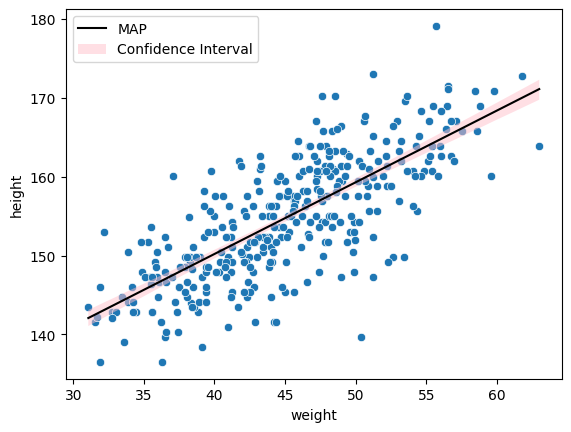

In [28]:
sns.scatterplot(data=DatAdults, x='weight', y='height')

plt.plot(
    [WeightMin, WeightMax],
    [AlphaMap + BetaMap * (WeightMin-WeightMean), AlphaMap + BetaMap * (WeightMax - WeightMean)],
    color = 'k',
    label = 'MAP'
)

plt.fill_between(
    ConfidenceIntervals['weight']
    , ConfidenceIntervals['LCI']
    , ConfidenceIntervals['UCI']
    , facecolor='pink'
    , alpha=0.5
    , label='Confidence Interval'
)

plt.legend()

Predicting height for a given weight

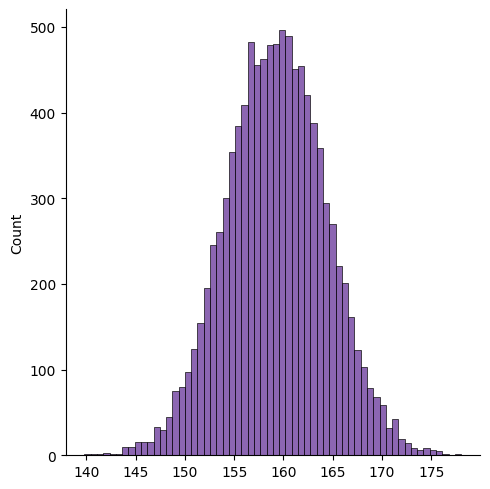

In [29]:
Weight = 50
sns.displot(
    norm.rvs(
        size = NSample
        , loc = SamplePosterior['alpha'] + SamplePosterior['beta'] * (Weight-WeightMean)
        , scale = SamplePosterior['sigma'])
    , color='rebeccapurple'
)

### Estimating prediction intervals

In [30]:
SampleHeight = norm.rvs(
    size = NSample,
    loc = SamplePosterior['alpha'] + SamplePosterior['beta'] * (WeightMin - WeightMean),
    scale = SamplePosterior['sigma']
)

PredictionIntervals = pd.DataFrame(np.quantile(SampleHeight, [ALPHA/2, 1-ALPHA/2]).reshape(1,2), columns=['LPI', 'UPI'])

In [31]:
for Weight in WeightSeq[1:]:
    SampleHeight = norm.rvs(
        size = NSample,
        loc = SamplePosterior['alpha'] + SamplePosterior['beta'] * (Weight - WeightMean),
        scale = SamplePosterior['sigma']
    )
    
    PredictionIntervals = pd.concat(
        [PredictionIntervals, pd.DataFrame(np.quantile(SampleHeight, [ALPHA/2, 1-ALPHA/2]).reshape(1,2), columns=['LPI', 'UPI'])]
    )

In [32]:
PredictionIntervals['weight'] = WeightSeq

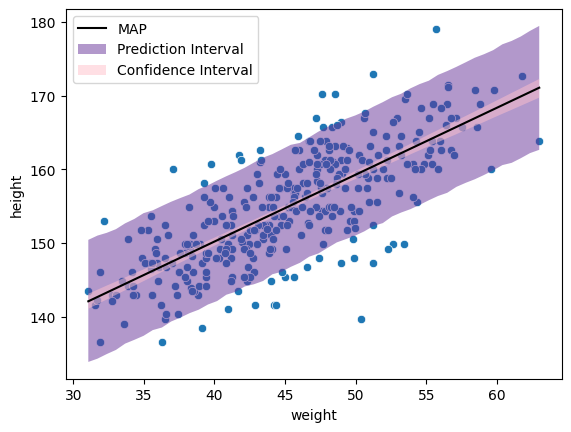

In [33]:
sns.scatterplot(data=DatAdults, x='weight', y='height')

plt.plot(
    [WeightMin, WeightMax],
    [AlphaMap + BetaMap * (WeightMin-WeightMean), AlphaMap + BetaMap * (WeightMax - WeightMean)],
    color = 'k',
    label = 'MAP'
)

plt.fill_between(
    PredictionIntervals['weight']
    , PredictionIntervals['LPI']
    , PredictionIntervals['UPI']
    , facecolor='rebeccapurple'
    , alpha=0.5
    , label='Prediction Interval'
)

plt.fill_between(
    ConfidenceIntervals['weight']
    , ConfidenceIntervals['LCI']
    , ConfidenceIntervals['UCI']
    , facecolor='pink'
    , alpha=0.5
    , label='Confidence Interval'
)

plt.legend()